In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans



BASE_DIR = Path.cwd().resolve()
MONTHLY_PATH = BASE_DIR.parents[1] / "data" / "processed" / "train_monthly.csv"
DATA_PATH = BASE_DIR.parents[1] / "data" / "raw" / "train.csv"

train = pd.read_csv(DATA_PATH)
monthly = pd.read_csv(MONTHLY_PATH)
print("monthly shape:", monthly.shape)
monthly.head()

monthly shape: (3734, 8)


,item_id,year,month,type,hs4,total_value,total_weight,total_quantity
0,AANGBULD,2022,1,1,4810,14276,17625.0,0.0
1,AANGBULD,2022,2,1,4810,52347,67983.0,0.0
2,AANGBULD,2022,3,1,4810,53549,69544.0,0.0
3,AANGBULD,2022,5,1,4810,26997,34173.0,0.0
4,AANGBULD,2022,6,1,4810,84489,103666.0,0.0


In [8]:
# [EDA 1단계] HS3 total_value lag

In [7]:

# 기존 monthly 불러오기 (train_clean or 만들었던 monthly)
monthly = pd.read_csv(MONTHLY_PATH)

# HS3 생성
monthly["hs3"] = monthly["hs4"].astype(str).str[:3]
monthly["ym"] = monthly["year"].astype(str) + "-" + monthly["month"].astype(str)

# HS3 total_value 시계열 pivot
pivot_hs3 = monthly.pivot_table(
    index="ym",
    columns="hs3",
    values="total_value",
    aggfunc="sum"
).fillna(0)

pivot_hs3 = pivot_hs3.sort_index()
pivot_hs3.head()


hs3,121,200,210,250,252,261,270,271,280,281,...,790,810,846,847,850,852,870,871,902,940
ym,,,,,,,,,,,,,,,,,,,,,
2022-1,471191.0,267743.0,242705.0,108699.0,1179252.0,0.0,0.0,0.0,1712098.0,168721512.0,...,571.0,2050641.0,375148.0,16488096.0,56825682.0,230828.0,7718.0,177783.0,0.0,19061787.0
2022-10,818048.0,167163.0,89292.0,60533.0,846360.0,0.0,3849.0,0.0,361661.0,106285724.0,...,0.0,2230204.0,27619.0,11505150.0,74266274.0,131112.0,89758.0,167609.0,128334.0,16844753.0
2022-11,416609.0,165669.0,141264.0,201344.0,343094.0,0.0,8900.0,0.0,983685.0,80278406.0,...,64073.0,2353949.0,300747.0,2960961.0,80310716.0,37050.0,55562.0,158411.0,20404.0,15840634.0
2022-12,480553.0,430356.0,71149.0,95875.0,2388068.0,0.0,11.0,0.0,1202155.0,104825564.0,...,26260.0,3073176.0,118677.0,1735979.0,72114336.0,157217.0,78405.0,77543.0,0.0,16987005.0
2022-2,497978.0,312664.0,120847.0,78853.0,1715532.0,0.0,88.0,1080.0,437766.0,121893065.0,...,32.0,2868542.0,59900.0,15648728.0,29377273.0,77269.0,24829.0,414114.0,891.0,13335477.0


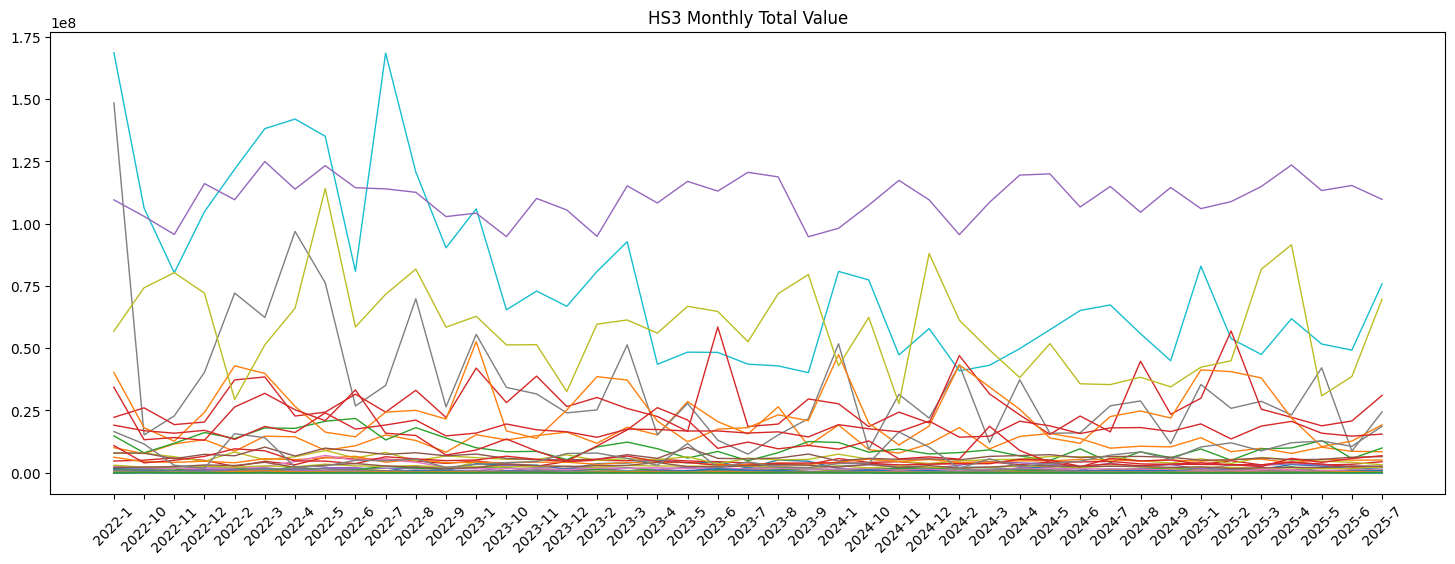

In [9]:
plt.figure(figsize=(18,6))
for col in pivot_hs3.columns:
    plt.plot(pivot_hs3.index, pivot_hs3[col], lw=1)

plt.title("HS3 Monthly Total Value")
plt.xticks(rotation=45)
plt.show()


In [10]:
def lag_corr(df, lag):
    df_s = df.shift(lag)
    return df_s.corrwith(df, axis=0)

# lag 1~6 correlation 계산
lag_corr_hs3 = {}
for L in range(1, 7):
    lag_corr_hs3[L] = pivot_hs3.shift(L).corrwith(pivot_hs3).sort_values(ascending=False)

# DataFrame 변환
lag_corr_df = pd.DataFrame(lag_corr_hs3)
lag_corr_df.head()


,1,2,3,4,5,6
hs3,,,,,,
121,0.096360,0.090175,-0.096831,-0.246392,0.262441,0.006411
200,0.277694,0.049247,0.440198,0.345469,0.216727,0.099154
210,-0.165216,-0.060472,-0.188855,0.035104,-0.014837,0.127360
250,0.180082,0.173881,-0.176744,-0.149432,-0.287178,-0.068914
252,-0.143565,-0.291935,0.085372,-0.010536,-0.072026,-0.132686


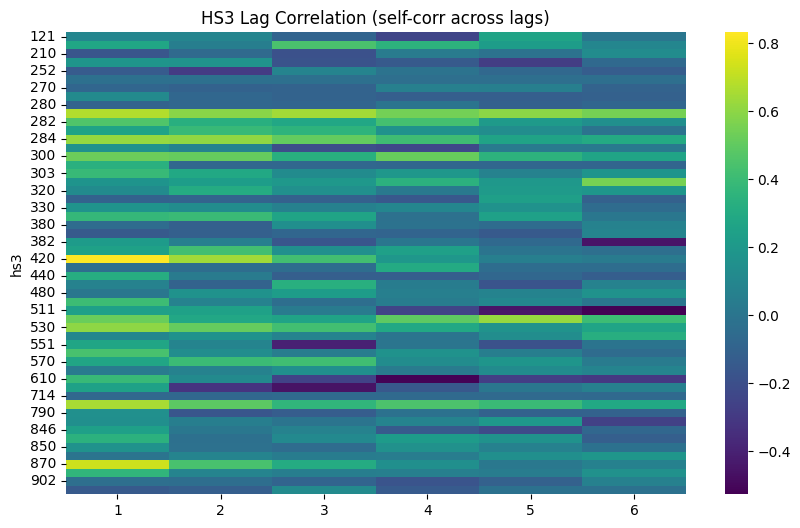

In [11]:
plt.figure(figsize=(10,6))
sns.heatmap(lag_corr_df, annot=False, cmap="viridis")
plt.title("HS3 Lag Correlation (self-corr across lags)")
plt.show()


In [12]:
# HS4 pivot 만들기 (value 기준)
pivot_hs4 = monthly.pivot_table(
    index="ym",
    columns="hs4",
    values="total_value",
    aggfunc="sum"
).fillna(0)

pivot_hs4 = pivot_hs4.sort_index()

# HS3 lag → HS4 corr 계산
corr_results = []

for hs3 in pivot_hs3.columns:
    for hs4 in pivot_hs4.columns:
        for lag in range(1,7):
            x = pivot_hs3[hs3].shift(lag)
            y = pivot_hs4[hs4]
            corr = np.corrcoef(x[lag:], y[lag:])[0,1]
            corr_results.append([hs3, hs4, lag, corr])

hs3_to_hs4_corr = pd.DataFrame(corr_results, columns=["hs3","hs4","lag","corr"])
hs3_to_hs4_corr.sort_values("corr", ascending=False).head(20)


/data/ephemeral/home/py310/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/ephemeral/home/py310/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,hs3,hs4,lag,corr
11686,430,3813,5,0.894613
22196,902,2710,3,0.860852
11286,420,4202,1,0.832441
11837,430,7142,6,0.817126
12057,440,3024,4,0.782976
11975,440,2710,6,0.777755
3539,280,3024,6,0.758166
3637,280,4408,2,0.732977
21937,871,4202,2,0.731570
21702,870,8708,1,0.731077


In [14]:
# hs3 생성
train["hs4"] = train["hs4"].astype(str).str.zfill(4)
train["hs3"] = train["hs4"].str[:3]

# item_id × ym value
monthly = (
    train.groupby(["item_id","year","month"],as_index=False)["value"].sum()
)

monthly["ym"] = pd.to_datetime(
    monthly["year"].astype(str)+"-"+monthly["month"].astype(str).str.zfill(2)
)

# HS3 total monthly
hs3_monthly = (
    train.groupby(["hs3","year","month"],as_index=False)["value"].sum()
)
hs3_monthly["ym"] = pd.to_datetime(
    hs3_monthly["year"].astype(str)+"-"+hs3_monthly["month"].astype(str).str.zfill(2)
)

pivot_hs3 = (
    hs3_monthly.pivot(index="hs3",columns="ym",values="value")
    .fillna(0)
)


In [15]:
def make_lags(df, lags=[1,2,3,4,5,6]):
    out = {}
    for lag in lags:
        out[f"lag_{lag}"] = df.shift(lag, axis=1)
    return out

hs3_lags = make_lags(pivot_hs3)


In [25]:
# HS4 monthly pivot
pivot_hs4 = (
    monthly.pivot(index="item_id",columns="ym",values="value")
    .fillna(0)
)

hs4_to_hs3 = train.groupby("item_id")["hs3"].first()

corr_records = []

for item in pivot_hs4.index:
    hs3 = hs4_to_hs3[item]
    b = pivot_hs4.loc[item].values.astype(float)

    for lag_name, lag_df in hs3_lags.items():
        a = lag_df.loc[hs3].values.astype(float)
        if np.std(a)==0 or np.std(b)==0:
            continue

        corr = np.corrcoef(a, b)[0,1]
        corr_records.append([item, hs3, lag_name, corr])

hs3_lag_corr = pd.DataFrame(
    corr_records, columns=["item_id","hs3","lag","corr"]
).sort_values("corr", ascending=False)

hs3_lag_corr.head(20)

# Nan값 존재 = HS3_total(lag)가 시계열성이 있는 HS4 / HS3 조합에만 큰 효과.

,item_id,hs3,lag,corr
0,AANGBULD,481,lag_1,NaN
1,AANGBULD,481,lag_2,NaN
2,AANGBULD,481,lag_3,NaN
3,AANGBULD,481,lag_4,NaN
4,AANGBULD,481,lag_5,NaN
5,AANGBULD,481,lag_6,NaN
6,AHMDUILJ,210,lag_1,NaN
7,AHMDUILJ,210,lag_2,NaN
8,AHMDUILJ,210,lag_3,NaN
9,AHMDUILJ,210,lag_4,NaN


In [17]:
def safe_corr(a,b):
    if np.std(a)==0 or np.std(b)==0:
        return 0
    return np.corrcoef(a,b)[0,1]

results = []

for item in pivot_hs4.index:
    b = pivot_hs4.loc[item].values.astype(float)
    hs3 = hs4_to_hs3[item]

    for hs3_code in pivot_hs3.index:
        a = pivot_hs3.loc[hs3_code].values.astype(float)

        best_corr = 0
        best_lag = None

        for L in range(1,7):
            if len(a) <= L:
                continue
            c = safe_corr(a[:-L], b[L:])
            if abs(c) > abs(best_corr):
                best_corr = c
                best_lag = L

        if best_lag is not None:
            results.append([hs3_code, item, best_lag, best_corr])

hs3_lead_hs4 = pd.DataFrame(results,
    columns=["lead_hs3","follow_hs4","lag","corr"]
).sort_values("corr", ascending=False)

hs3_lead_hs4.head(20)


,lead_hs3,follow_hs4,lag,corr
2327,261,LLHREMKS,1,0.886896
538,902,BSRMSVTC,3,0.860032
1843,271,IGDVVKUD,5,0.857499
3435,520,QVLMOEYE,5,0.842610
3428,420,QVLMOEYE,1,0.833491
3303,281,QRKRBYJL,1,0.810138
1627,271,GMBFCMIU,3,0.794358
871,271,DJBLNPNC,6,0.794174
3419,310,QVLMOEYE,4,0.791602
4112,280,TANNMIMB,5,0.788911


In [18]:
vol_records = []

for item in pivot_hs4.index:
    x = pivot_hs4.loc[item].values.astype(float)
    zero_ratio = np.mean(x==0)
    vol = np.std(x)
    mean = np.mean(x)
    cv = vol / (mean+1e-9)

    vol_records.append([item, zero_ratio, vol, cv])

meta_vol = pd.DataFrame(vol_records,
                        columns=["item_id","zero_ratio","volatility","cv"])

meta_vol.head()


,item_id,zero_ratio,volatility,cv
0,AANGBULD,0.325581,1.435857e+05,1.708994
1,AHMDUILJ,0.000000,4.551154e+04,0.358842
2,ANWUJOKX,0.813953,2.034624e+04,2.497477
3,APQGTRMF,0.023256,2.095909e+05,0.814869
4,ATLDMDBO,0.000000,3.234730e+07,0.539145


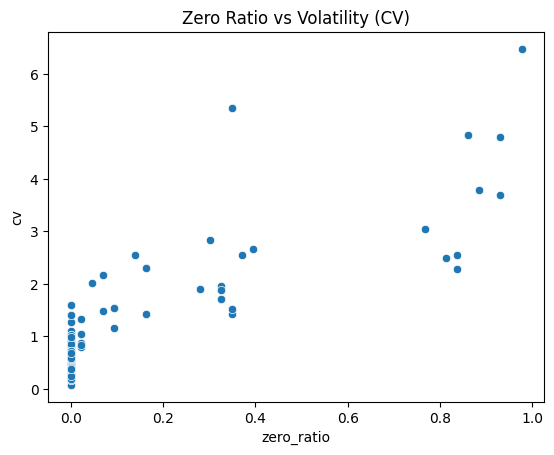

In [20]:
sns.scatterplot(data=meta_vol, x="zero_ratio", y="cv")
plt.title("Zero Ratio vs Volatility (CV)")
plt.show()


pairs_hs4: (3242, 4)


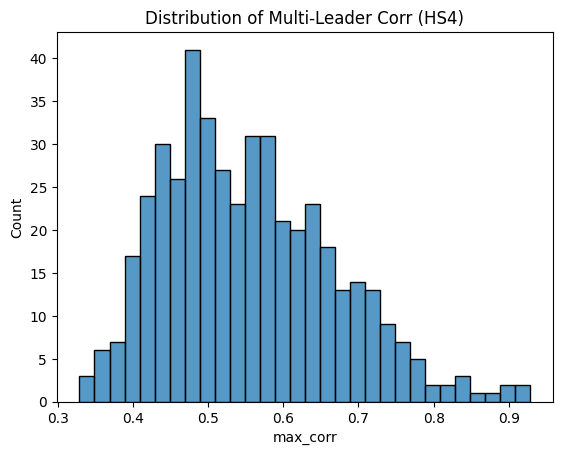

In [27]:
def safe_corr(x, y):
    if np.std(x) == 0 or np.std(y) == 0:
        return 0.0
    return float(np.corrcoef(x, y)[0,1])

def find_comovement_pairs(pivot, max_lag=6, min_nonzero=12, corr_threshold=0.3):
    items = pivot.index.to_list()
    months = pivot.columns.to_list()
    n_months = len(months)

    results = []

    for leader in items:
        x = pivot.loc[leader].values.astype(float)
        if np.count_nonzero(x) < min_nonzero:
            continue

        for follower in items:
            if follower == leader:
                continue

            y = pivot.loc[follower].values.astype(float)
            if np.count_nonzero(y) < min_nonzero:
                continue

            best_lag = None
            best_corr = 0.0

            for lag in range(1, max_lag+1):
                if n_months <= lag:
                    continue
                corr = safe_corr(x[:-lag], y[lag:])
                if abs(corr) > abs(best_corr):
                    best_corr = corr
                    best_lag = lag

            if best_lag is not None and abs(best_corr) >= corr_threshold:
                results.append({
                    "leading_item_id": leader,
                    "following_item_id": follower,
                    "best_lag": best_lag,
                    "max_corr": best_corr
                })

    return pd.DataFrame(results)

# HS4용 pivot이 이미 있다면 pivot_hs4 사용
pairs_hs4 = find_comovement_pairs(pivot_hs4, corr_threshold=0.3)
print("pairs_hs4:", pairs_hs4.shape)
pairs_hs4.head()

topN = (
    pairs_hs4
    .sort_values(["following_item_id", "max_corr"], ascending=[True, False])
    .groupby("following_item_id")
    .head(5)
    .reset_index(drop=True)
)

topN.head()

sns.histplot(topN["max_corr"], bins=30)
plt.title("Distribution of Multi-Leader Corr (HS4)")
plt.show()

In [28]:
pairs_hs4 = find_comovement_pairs(pivot_hs4, corr_threshold=0.3)

# follower별로 top N leader 선정
topN = pairs_hs4.groupby("following_item_id") \
         .apply(lambda df: df.sort_values("max_corr", ascending=False).head(5)) \
         .reset_index(drop=True)

topN.head(20)


/tmp/ipykernel_147805/4037808625.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: df.sort_values("max_corr", ascending=False).head(5)) \


,leading_item_id,following_item_id,best_lag,max_corr
0,ZKENOUDA,AANGBULD,1,0.593889
1,ZGJXVMNI,AANGBULD,3,0.592394
2,ELQGMQWE,AANGBULD,1,0.579046
3,RJGPVEXX,AANGBULD,3,0.572772
4,LLHREMKS,AANGBULD,6,0.491534
5,PYZMVUWD,AHMDUILJ,5,0.435046
6,OJIFIHMZ,AHMDUILJ,2,0.433560
7,OGAFEHLU,AHMDUILJ,5,0.432425
8,LPHPPJUG,AHMDUILJ,3,0.422500
9,HCDTGMST,AHMDUILJ,6,0.409003


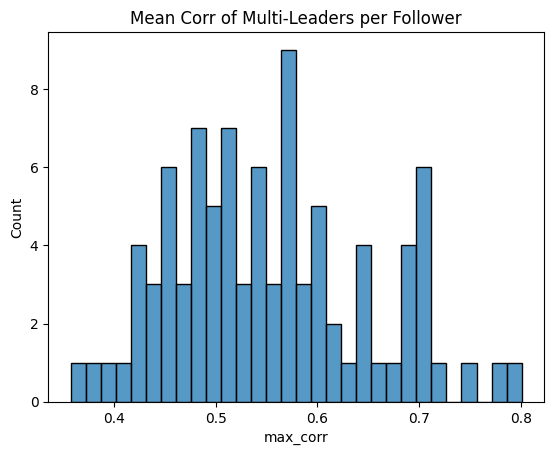

In [30]:
agg_corr = topN.groupby("following_item_id")["max_corr"].mean()

sns.histplot(agg_corr, bins=30)
plt.title("Mean Corr of Multi-Leaders per Follower")
plt.show()


In [31]:
sns.set(style="whitegrid")

# 1) follower별 상위 5개 leader (이미 구했다면 생략 가능)
topN = (
    pairs_hs4
    .sort_values(["following_item_id", "max_corr"], ascending=[True, False])
    .groupby("following_item_id")
    .head(5)
    .reset_index(drop=True)
)

# 2) follower별 mean_corr 계산
agg_corr = topN.groupby("following_item_id")["max_corr"].mean().rename("mean_corr")
agg_corr = agg_corr.reset_index()

# 3) volatility/zero_ratio와 merge
meta_vol = meta_vol.copy()
follower_meta = meta_vol.merge(
    agg_corr,
    left_on="item_id",
    right_on="following_item_id",
    how="inner"
)


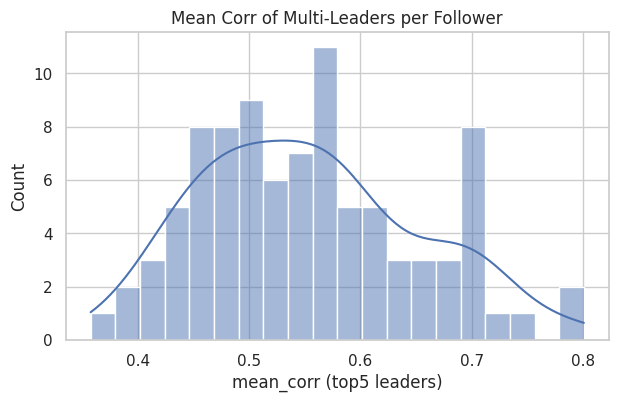

In [32]:
plt.figure(figsize=(7,4))
sns.histplot(agg_corr["mean_corr"], bins=20, kde=True)
plt.title("Mean Corr of Multi-Leaders per Follower")
plt.xlabel("mean_corr (top5 leaders)")
plt.show()


In [33]:
def label_segment(x):
    if x >= 0.65:
        return "A_strong"
    elif x >= 0.50:
        return "B_medium"
    else:
        return "C_weak"

agg_corr["segment"] = agg_corr["mean_corr"].apply(label_segment)

agg_corr["segment"].value_counts()


segment
B_medium    42
C_weak      31
A_strong    18
Name: count, dtype: int64

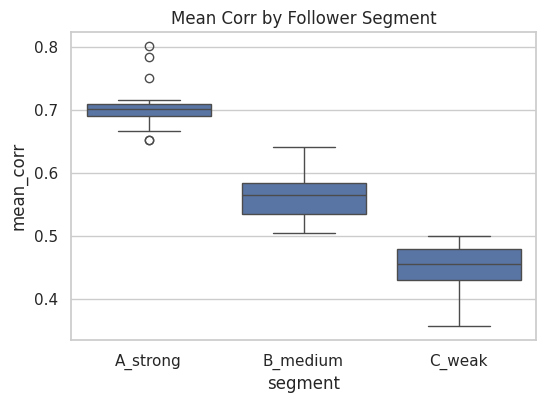

In [34]:
plt.figure(figsize=(6,4))
sns.boxplot(data=agg_corr, x="segment", y="mean_corr", order=["A_strong","B_medium","C_weak"])
plt.title("Mean Corr by Follower Segment")
plt.show()


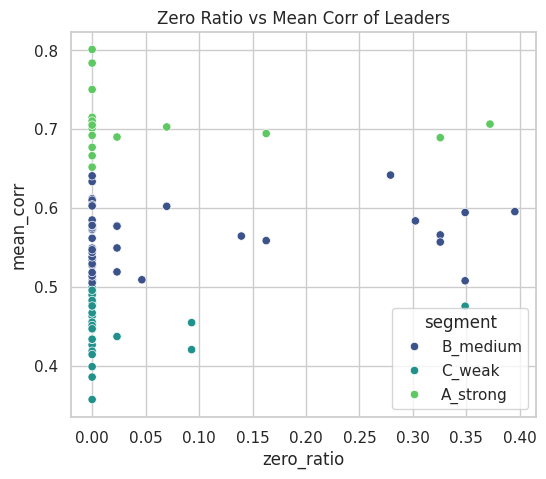

In [35]:
plt.figure(figsize=(6,5))
sns.scatterplot(
    data=follower_meta,
    x="zero_ratio",
    y="mean_corr",
    hue=follower_meta["mean_corr"].apply(label_segment),
    palette="viridis"
)
plt.title("Zero Ratio vs Mean Corr of Leaders")
plt.xlabel("zero_ratio")
plt.ylabel("mean_corr")
plt.legend(title="segment")
plt.show()


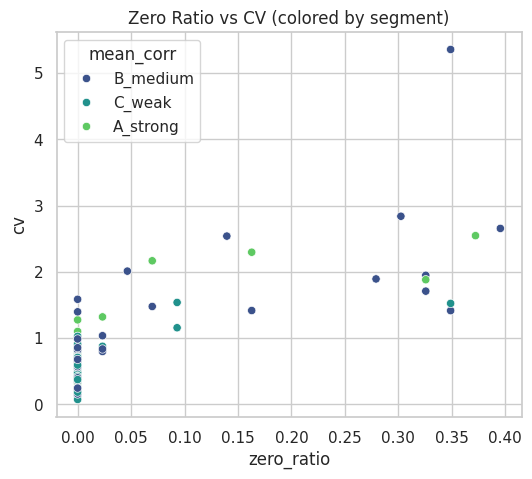

In [36]:
plt.figure(figsize=(6,5))
sns.scatterplot(
    data=follower_meta,
    x="zero_ratio",
    y="cv",
    hue=follower_meta["mean_corr"].apply(label_segment),
    palette="viridis"
)
plt.title("Zero Ratio vs CV (colored by segment)")
plt.xlabel("zero_ratio")
plt.ylabel("cv")
plt.show()


In [37]:
hs3_pairs_strong = hs3_lead_hs4[hs3_lead_hs4["corr"] >= 0.5].copy()
hs3_pairs_strong["type"] = "HS3_lead"

hs3_pairs_strong.head()

hs4_pairs_strong = pairs_hs4[pairs_hs4["max_corr"] >= 0.5].copy()
hs4_pairs_strong = hs4_pairs_strong.rename(columns={"max_corr":"corr"})
hs4_pairs_strong["type"] = "HS4_lead"

hs4_pairs_strong.head()


,leading_item_id,following_item_id,best_lag,corr,type
3,AANGBULD,DEWLVASR,6,0.640221,HS4_lead
7,AANGBULD,FTSVTTSR,3,0.531400,HS4_lead
8,AANGBULD,GKQIJYDH,6,0.582501,HS4_lead
18,AANGBULD,NAQIHUKZ,2,0.525490,HS4_lead
30,AANGBULD,VUAFAIYJ,2,0.509968,HS4_lead


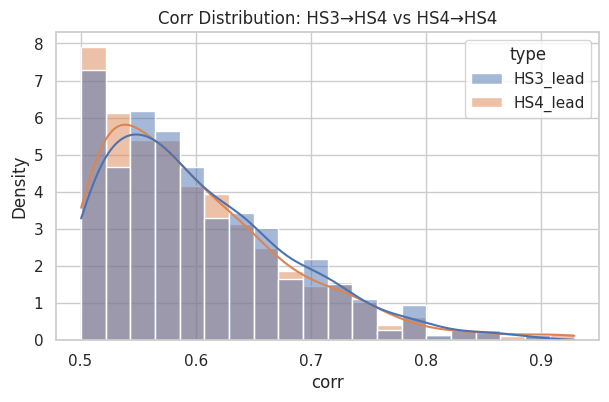

In [38]:
combined_corr = pd.concat([
    hs3_pairs_strong[["corr","type"]],
    hs4_pairs_strong[["corr","type"]]
])

plt.figure(figsize=(7,4))
sns.histplot(data=combined_corr, x="corr", hue="type", bins=20, kde=True, stat="density", common_norm=False)
plt.title("Corr Distribution: HS3→HS4 vs HS4→HS4")
plt.xlabel("corr")
plt.show()


In [39]:
# follower 기준 HS3 최고 corr
hs3_best_per_f = (
    hs3_lead_hs4.groupby("follow_hs4")["corr"]
    .max()
    .rename("hs3_best_corr")
)

# follower 기준 HS4(멀티리더) 최고 corr
hs4_best_per_f = (
    pairs_hs4.groupby("following_item_id")["max_corr"]
    .max()
    .rename("hs4_best_corr")
)

comp = pd.concat([hs3_best_per_f, hs4_best_per_f], axis=1).dropna()
comp.head()


,hs3_best_corr,hs4_best_corr
AANGBULD,0.592389,0.593889
AHMDUILJ,0.409003,0.435046
APQGTRMF,0.571593,0.607672
ATLDMDBO,0.728171,0.780910
AXULOHBQ,0.744647,0.744647


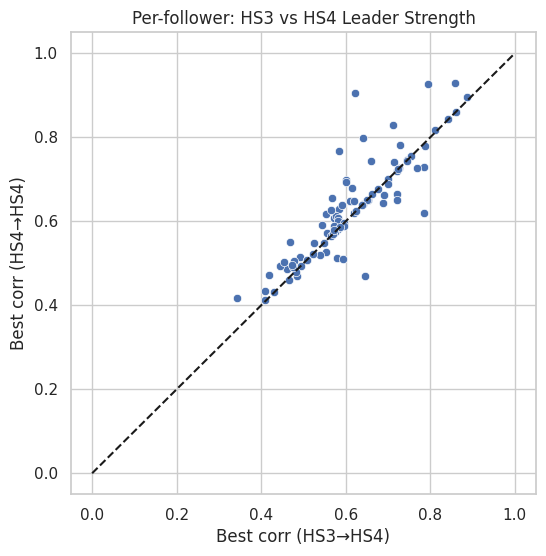

In [40]:
plt.figure(figsize=(6,6))
sns.scatterplot(data=comp, x="hs3_best_corr", y="hs4_best_corr")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("Best corr (HS3→HS4)")
plt.ylabel("Best corr (HS4→HS4)")
plt.title("Per-follower: HS3 vs HS4 Leader Strength")
plt.show()


In [41]:
strong_followers = agg_corr[agg_corr["segment"]=="A_strong"]["following_item_id"].tolist()
strong_followers[:10]


['ATLDMDBO',
 'AXULOHBQ',
 'BSRMSVTC',
 'BTMOEMEP',
 'DJBLNPNC',
 'DNMPSKTB',
 'FDXPMYGF',
 'FTSVTTSR',
 'GYHKIVQT',
 'IGDVVKUD']

In [42]:
example_f = "ATLDMDBO"  # strong_followers[0]로 바꿔도 됨

# 해당 follower의 top5 leader
leaders_f = topN[topN["following_item_id"]==example_f] \
              .sort_values("max_corr", ascending=False) \
              .head(5)

leaders_f


,leading_item_id,following_item_id,best_lag,max_corr
15,QRKRBYJL,ATLDMDBO,2,0.780910
16,VBYCLTYZ,ATLDMDBO,2,0.730392
17,BTMOEMEP,ATLDMDBO,6,0.689814
18,OGAFEHLU,ATLDMDBO,6,0.666760
19,DNMPSKTB,ATLDMDBO,3,0.660281


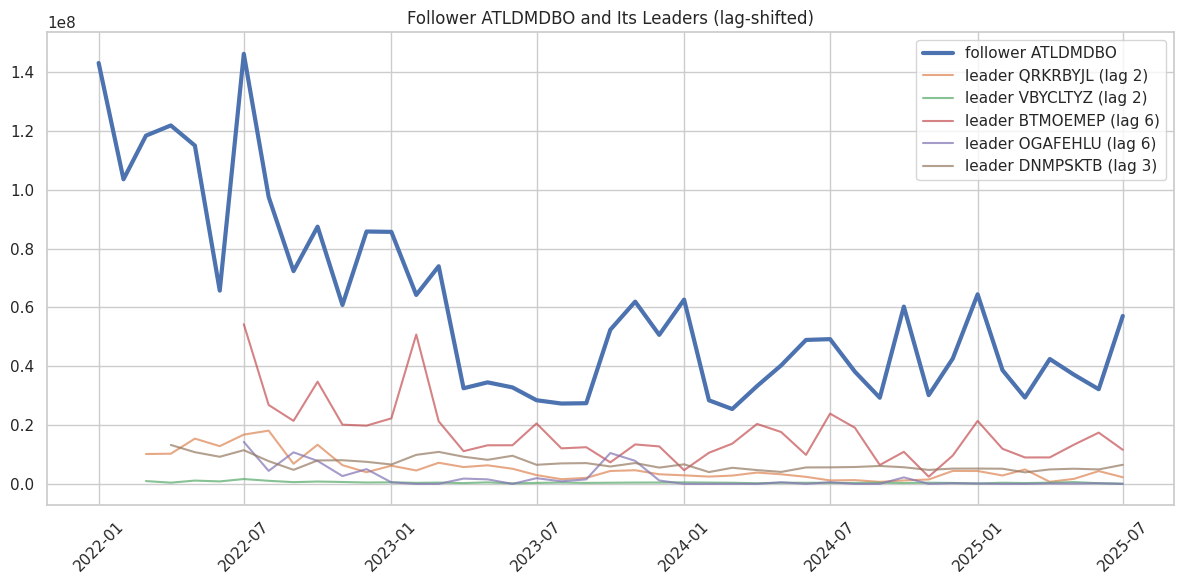

In [43]:
# 시계열 데이터 가져오기
f_series = pivot_hs4.loc[example_f]

plt.figure(figsize=(12,6))
plt.plot(f_series.index, f_series.values, label=f"follower {example_f}", linewidth=3)

for _, row in leaders_f.iterrows():
    leader = row["leading_item_id"]
    lag = int(row["best_lag"])
    s = pivot_hs4.loc[leader]
    # follower 타임라인에 맞춰 shift
    shifted = s.shift(lag)
    plt.plot(shifted.index, shifted.values, alpha=0.7, label=f"leader {leader} (lag {lag})")

plt.title(f"Follower {example_f} and Its Leaders (lag-shifted)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [44]:
# HS3_cluster_id (HS3 시계열 클러스터링)

In [46]:
# hs3 시계열 (이미 있음)
# pivot_hs3: index=hs3, columns=ym, values=total_value

# 1) 스케일링 (시간축 기준 표준화)
X = pivot_hs3.copy()
X = X.div(X.mean(axis=1).replace(0,1), axis=0)  # scale by mean to reduce size effect
X = X.fillna(0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2) KMeans로 군집 (예: K=4~6)
k = 5
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
hs3_cluster_labels = kmeans.fit_predict(X_scaled)

hs3_cluster = pd.DataFrame({
    "hs3": pivot_hs3.index,
    "hs3_cluster_id": hs3_cluster_labels
})

hs3_cluster.head()


,hs3,hs3_cluster_id
0,121,0
1,200,0
2,210,0
3,250,0
4,252,0


In [47]:
# item_id → hs3 매핑 (train에서)
item_hs3 = train.groupby("item_id")["hs4"].first().astype(str).str[:3].rename("hs3")
item_cluster = item_hs3.reset_index().merge(hs3_cluster, on="hs3", how="left")
item_cluster.head()


,item_id,hs3,hs3_cluster_id
0,AANGBULD,481,3
1,AHMDUILJ,210,0
2,ANWUJOKX,440,0
3,APQGTRMF,810,0
4,ATLDMDBO,281,0


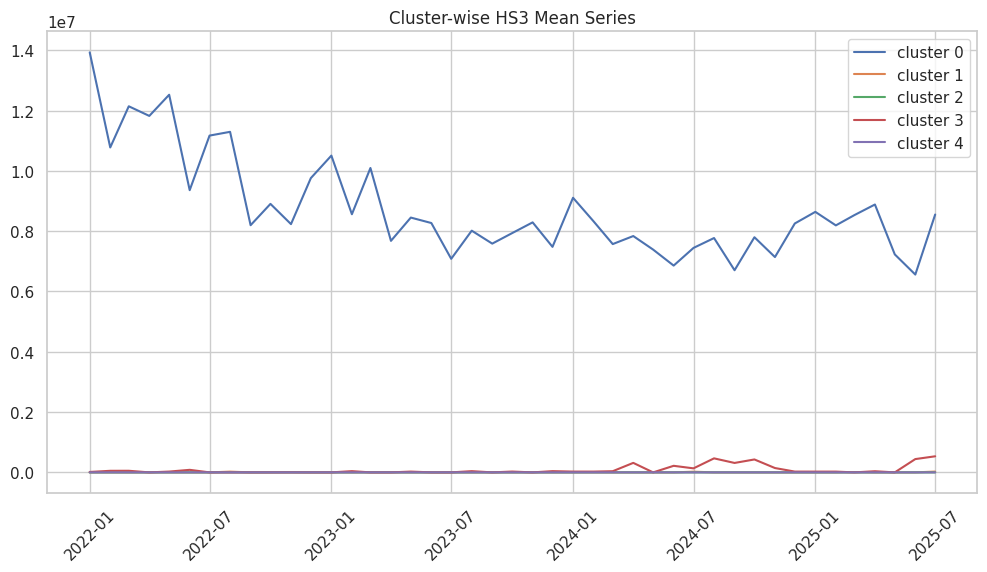

In [49]:
plt.figure(figsize=(12,6))
for cid in sorted(hs3_cluster["hs3_cluster_id"].unique()):
    members = pivot_hs3.loc[hs3_cluster[hs3_cluster["hs3_cluster_id"]==cid]["hs3"]]
    mean_series = members.mean(axis=0)
    plt.plot(mean_series.index, mean_series.values, label=f"cluster {cid}")
plt.legend()
plt.xticks(rotation=45)
plt.title("Cluster-wise HS3 Mean Series")
plt.show()


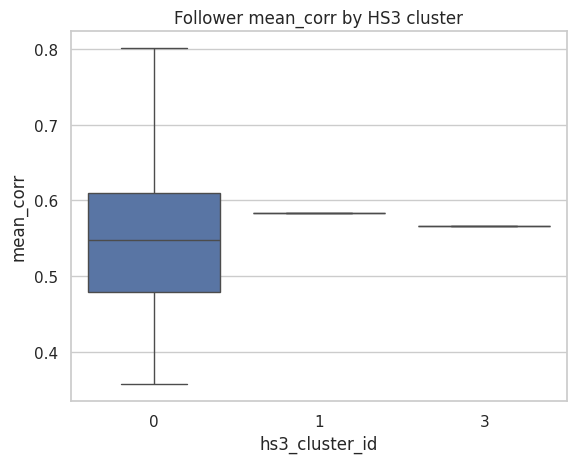

In [50]:
# follower_meta: item_id, zero_ratio, cv, mean_corr (이미 만들었지)
follower_with_cluster = follower_meta.merge(
    item_cluster,
    left_on="item_id",
    right_on="item_id",
    how="left"
)

sns.boxplot(data=follower_with_cluster, x="hs3_cluster_id", y="mean_corr")
plt.title("Follower mean_corr by HS3 cluster")
plt.show()


In [52]:
# HS3_group_rolling (rolling mean/std)

In [53]:
# pivot_hs3: hs3 × ym

hs3_roll3 = pivot_hs3.rolling(window=3, axis=1, min_periods=1).mean()
hs3_roll6 = pivot_hs3.rolling(window=6, axis=1, min_periods=1).mean()

# item별로, 자신이 속한 hs3의 rolling series와 corr 측정
records = []
for item in pivot_hs4.index:
    hs3 = item_hs3[item]
    b = pivot_hs4.loc[item].values.astype(float)

    for name, roll_df in [("roll3", hs3_roll3), ("roll6", hs3_roll6)]:
        a = roll_df.loc[hs3].values.astype(float)
        if np.std(a)==0 or np.std(b)==0:
            continue
        corr = np.corrcoef(a, b)[0,1]
        records.append([item, hs3, name, corr])

hs3_roll_corr = pd.DataFrame(records, columns=["item_id","hs3","roll_type","corr"])
hs3_roll_corr.head()


/tmp/ipykernel_147805/3122338142.py:3: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  hs3_roll3 = pivot_hs3.rolling(window=3, axis=1, min_periods=1).mean()
/tmp/ipykernel_147805/3122338142.py:4: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  hs3_roll6 = pivot_hs3.rolling(window=6, axis=1, min_periods=1).mean()


,item_id,hs3,roll_type,corr
0,AANGBULD,481,roll3,0.842907
1,AANGBULD,481,roll6,0.587293
2,AHMDUILJ,210,roll3,0.639006
3,AHMDUILJ,210,roll6,0.494844
4,ANWUJOKX,440,roll3,0.021895


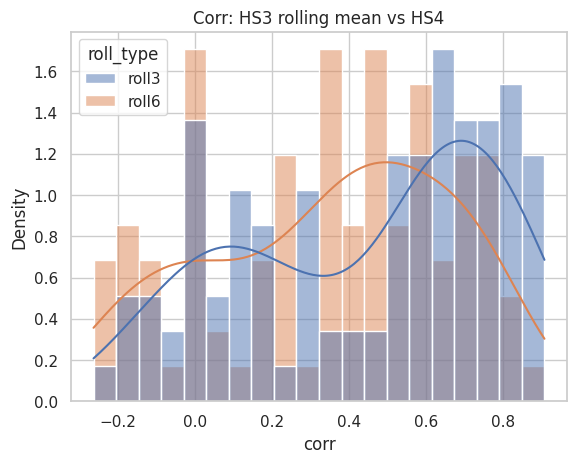

In [54]:
sns.histplot(data=hs3_roll_corr, x="corr", hue="roll_type", bins=20, kde=True, stat="density", common_norm=False)
plt.title("Corr: HS3 rolling mean vs HS4")
plt.show()


In [55]:
# HS2_total(lag)

/data/ephemeral/home/py310/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/ephemeral/home/py310/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


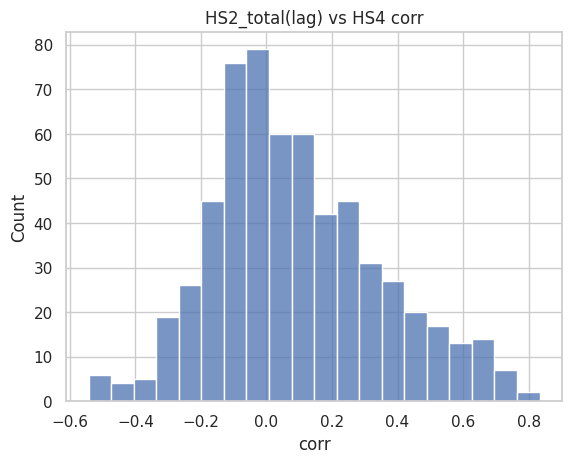

In [56]:
# hs2 만들기
train["hs2"] = train["hs4"].astype(str).str[:2]

hs2_monthly = (
    train.groupby(["hs2","year","month"], as_index=False)["value"].sum()
)
hs2_monthly["ym"] = pd.to_datetime(
    hs2_monthly["year"].astype(str)+"-"+hs2_monthly["month"].astype(str).str.zfill(2)
)

pivot_hs2 = hs2_monthly.pivot(index="hs2", columns="ym", values="value").fillna(0)

# hs2_total(lag) → HS4 corr
records = []
for item in pivot_hs4.index:
    b = pivot_hs4.loc[item].values.astype(float)
    hs2 = train.groupby("item_id")["hs2"].first()[item]

    for lag in range(1,7):
        a = pivot_hs2.loc[hs2].shift(lag).values.astype(float)
        if np.std(a)==0 or np.std(b)==0:
            continue
        c = np.corrcoef(a[lag:], b[lag:])[0,1]
        records.append([item, hs2, lag, c])

hs2_lag_corr = pd.DataFrame(records, columns=["item_id","hs2","lag","corr"])

sns.histplot(hs2_lag_corr["corr"], bins=20)
plt.title("HS2_total(lag) vs HS4 corr")
plt.show()


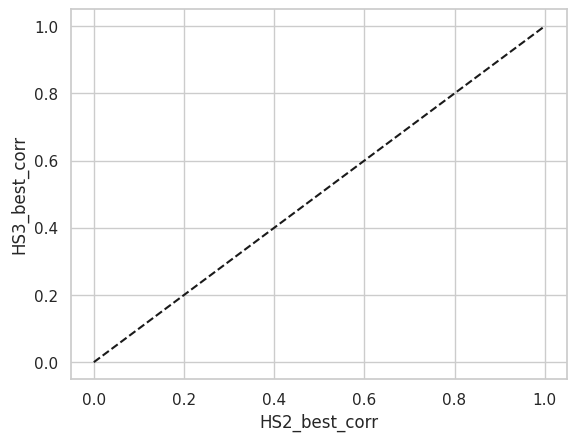

In [57]:
hs2_best = hs2_lag_corr.groupby("item_id")["corr"].max().rename("hs2_best_corr")
hs3_best = hs3_lag_corr.groupby("item_id")["corr"].max().rename("hs3_best_corr")

comp2 = pd.concat([hs2_best, hs3_best], axis=1).dropna()

sns.scatterplot(data=comp2, x="hs2_best_corr", y="hs3_best_corr")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("HS2_best_corr")
plt.ylabel("HS3_best_corr")
plt.show()


In [58]:
# relative_position (item vs HS3 mean)

In [68]:
# monthly: item_id × ym (value)
# hs3_monthly: hs3 × ym (value)
monthly["ym"] = pd.to_datetime(
    monthly["year"].astype(str) + "-" + monthly["month"].astype(str).str.zfill(2)
)

item_monthly = monthly.pivot(index="item_id", columns="ym", values="total_value").fillna(0)

# hs3_total pivot (pivot_hs3)를 item에 맞춰 align
rel_records = []

for item in item_monthly.index:
    hs3 = item_hs3[item]
    item_series = item_monthly.loc[item]
    hs3_series = pivot_hs3.loc[hs3]

    # 0 division 방지
    ratio = item_series / (hs3_series.replace(0,np.nan))
    # time-wise 평균 비율, std
    rel_mean = ratio.mean(skipna=True)
    rel_std = ratio.std(skipna=True)

    rel_records.append([item, hs3, rel_mean, rel_std])

rel_pos = pd.DataFrame(rel_records, columns=["item_id","hs3","rel_mean","rel_std"])
rel_pos.head()


,item_id,hs3,rel_mean,rel_std
0,AANGBULD,481,1.000000,0.000000
1,AHMDUILJ,210,1.000000,0.000000
2,ANWUJOKX,440,0.158249,0.347885
3,APQGTRMF,810,0.098723,0.082221
4,ATLDMDBO,281,0.748830,0.075574


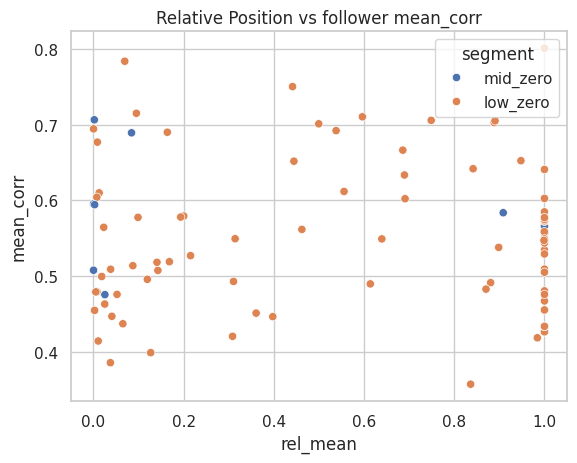

In [70]:
def segment_by_zero_ratio(x):
    if x > 0.7:
        return "high_zero"
    elif x > 0.3:
        return "mid_zero"
    else:
        return "low_zero"

follower_meta["segment"] = follower_meta["zero_ratio"].apply(segment_by_zero_ratio)

rel_with_meta = follower_meta.merge(rel_pos, on="item_id", how="left")

sns.scatterplot(data=rel_with_meta, x="rel_mean", y="mean_corr", hue="segment")
plt.title("Relative Position vs follower mean_corr")
plt.show()


In [61]:
# calendar feature (month, seasonality)

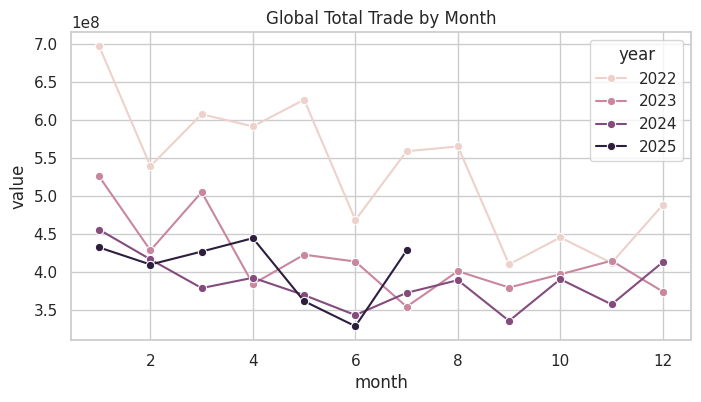

In [62]:
monthly_total = (
    train.groupby(["year","month"], as_index=False)["value"].sum()
)

plt.figure(figsize=(8,4))
sns.lineplot(data=monthly_total, x="month", y="value", hue="year", marker="o")
plt.title("Global Total Trade by Month")
plt.show()


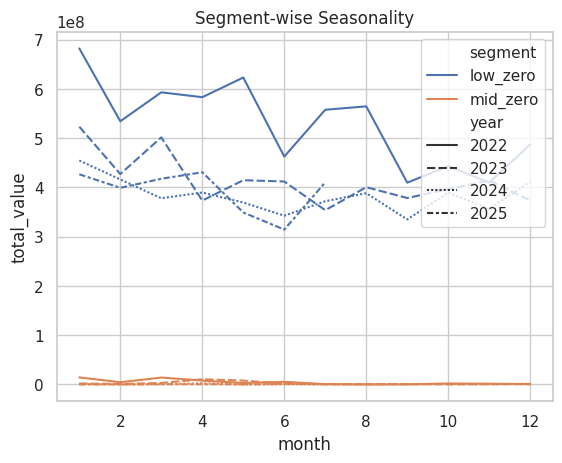

In [74]:
# follower_meta: item_id, segment
item_monthly_long = monthly[["item_id","year","month","total_value"]].merge(
    follower_meta[["item_id","segment"]],
    on="item_id",
    how="left"
)

seg_monthly = (
    item_monthly_long.groupby(["segment","year","month"], as_index=False)["total_value"].sum()
)

sns.lineplot(data=seg_monthly, x="month", y="total_value", hue="segment", style="year")
plt.title("Segment-wise Seasonality")
plt.show()


In [64]:
# centrality (network 중심성)

In [65]:
import networkx as nx

# HS4 lead-follow 네트워크
G = nx.DiGraph()

for row in pairs_hs4.itertuples(index=False):
    G.add_edge(row.leading_item_id, row.following_item_id, weight=row.max_corr)

# 중심성 지표 계산
deg_centrality = nx.degree_centrality(G)
in_centrality = nx.in_degree_centrality(G)
out_centrality = nx.out_degree_centrality(G)

centrality_df = pd.DataFrame({
    "item_id": list(deg_centrality.keys()),
    "deg_cent": list(deg_centrality.values()),
    "in_cent": [in_centrality.get(n,0) for n in deg_centrality.keys()],
    "out_cent": [out_centrality.get(n,0) for n in deg_centrality.keys()],
})
centrality_df.head()


,item_id,deg_cent,in_cent,out_cent
0,AANGBULD,0.811111,0.400000,0.411111
1,APQGTRMF,1.011111,0.488889,0.522222
2,BEZYMBBT,1.077778,0.600000,0.477778
3,DDEXPPXU,0.433333,0.233333,0.200000
4,DEWLVASR,1.044444,0.533333,0.511111


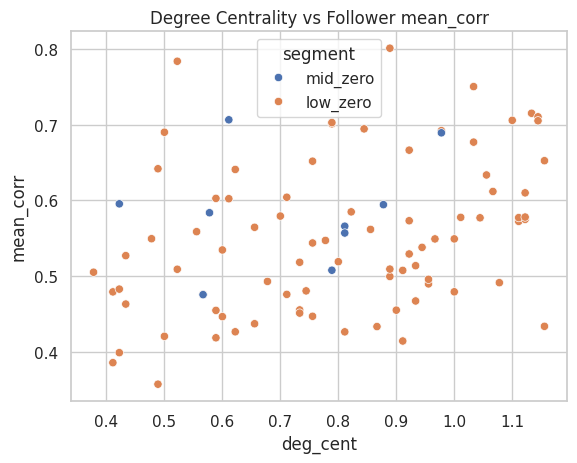

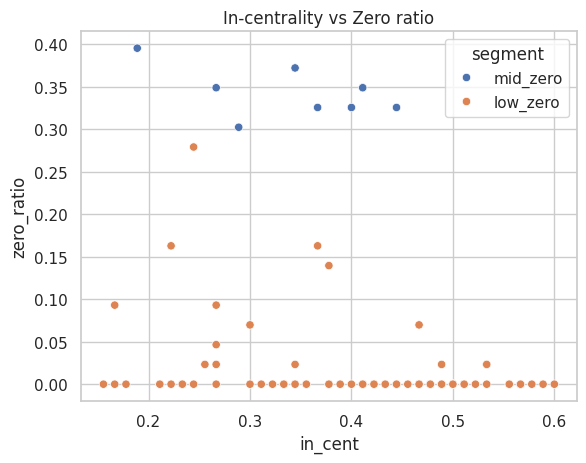

In [75]:
cent_with_meta = follower_meta.merge(centrality_df, on="item_id", how="left")

sns.scatterplot(data=cent_with_meta, x="deg_cent", y="mean_corr", hue="segment")
plt.title("Degree Centrality vs Follower mean_corr")
plt.show()

sns.scatterplot(data=cent_with_meta, x="in_cent", y="zero_ratio", hue="segment")
plt.title("In-centrality vs Zero ratio")
plt.show()


In [76]:
# Final_EDA: 최종 FE 적용 조건 알아보기

In [81]:
df = pd.read_csv(DATA_PATH)

# year, month 결합
df["ym"] = pd.to_datetime(df["year"].astype(str) + "-" + df["month"].astype(str).str.zfill(2))

# hs3 추가
df["hs4"] = df["hs4"].astype(str).str.zfill(4)
df["hs3"] = df["hs4"].str[:3]


# === 1. item_id × ym pivot (pivot_item) ===
pivot_item = (
    df.groupby(["item_id","ym"])["value"]
      .sum()
      .reset_index()
      .pivot(index="item_id", columns="ym", values="value")
      .fillna(0)
)


# === 2. hs3 × ym pivot (pivot_hs3_total) ===
pivot_hs3 = (
    df.groupby(["hs3","ym"])["value"]
      .sum()
      .reset_index()
      .pivot(index="hs3", columns="ym", values="value")
      .fillna(0)
)


# === 3. follower_meta (zero_ratio + volatility + hs3) ===
def zero_ratio(x):
    return (x == 0).mean()

def volatility(x):
    return x.std()

records = []
for item in pivot_item.index:
    x = pivot_item.loc[item].values.astype(float)
    zr = zero_ratio(x)
    vol = volatility(x)
    cv = vol / (np.mean(x)+1e-6)

    hs3 = (
        df[df["item_id"]==item]["hs3"]
        .mode().iloc[0]
    )

    records.append([item, hs3, zr, vol, cv])

follower_meta = pd.DataFrame(records,
                             columns=["item_id","hs3","zero_ratio","volatility","cv"])


# === 4. HS3 → item lead-follow pairs 정의 함수 ===
def safe_corr(x, y):
    if np.std(x)==0 or np.std(y)==0: 
        return 0.0
    return float(np.corrcoef(x,y)[0,1])

lags = [1,2,3,4,5,6]

pairs_records = []
for item in pivot_item.index:
    follower = item
    f_series = pivot_item.loc[follower].values.astype(float)

    hs3 = follower_meta.loc[follower_meta.item_id==item,"hs3"].iloc[0]
    h_series = pivot_hs3.loc[hs3].values.astype(float)

    for lag in lags:
        if len(f_series) <= lag:
            continue
        corr = safe_corr(f_series[lag:], h_series[:-lag])
        pairs_records.append([hs3, follower, lag, corr])

pairs_hs3 = pd.DataFrame(
    pairs_records,
    columns=["lead_hs3","follow_item","lag","corr"]
)

/data/ephemeral/home/py310/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/ephemeral/home/py310/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


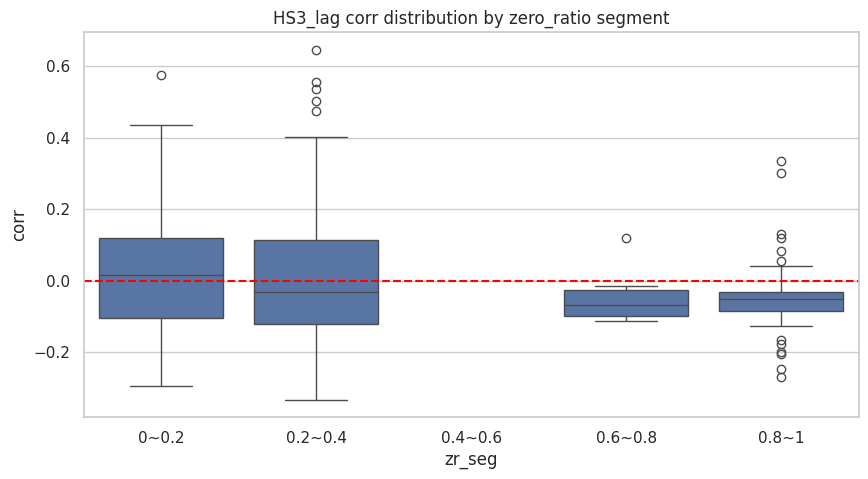

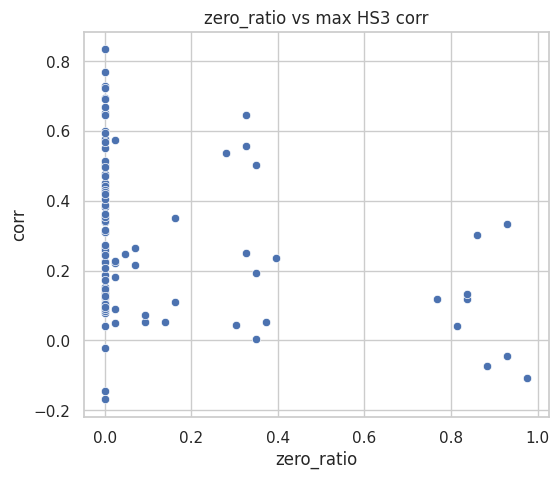

In [82]:

# 1. follower_corr 계산 (HS3_total(lag) vs item)
lags = [1,2,3,4,5,6]
records = []

for item in pivot_item.index:
    series_item = pivot_item.loc[item].values.astype(float)
    zr = follower_meta.loc[follower_meta.item_id == item, "zero_ratio"].iloc[0]

    hs3 = follower_meta.loc[follower_meta.item_id == item, "hs3"].iloc[0]
    hs3_series = pivot_hs3.loc[hs3].values.astype(float)

    for lag in lags:
        if len(series_item) <= lag:
            continue
        corr = np.corrcoef(series_item[lag:], hs3_series[:-lag])[0,1]
        records.append([item, hs3, lag, corr, zr])

df_lag_corr = pd.DataFrame(records, columns=["item_id","hs3","lag","corr","zero_ratio"])

# 2. zero_ratio segmentation
df_lag_corr["zr_seg"] = pd.cut(df_lag_corr["zero_ratio"],
                               bins=[0,0.2,0.4,0.6,0.8,1],
                               labels=["0~0.2","0.2~0.4","0.4~0.6","0.6~0.8","0.8~1"])

# 3. 박스플롯
plt.figure(figsize=(10,5))
sns.boxplot(data=df_lag_corr, x="zr_seg", y="corr")
plt.title("HS3_lag corr distribution by zero_ratio segment")
plt.axhline(0, color="red", linestyle="--")
plt.show()

# 4. zero_ratio vs max_corr scatter
df_item_max = df_lag_corr.groupby("item_id")["corr"].max().reset_index()
df_item_max = df_item_max.merge(follower_meta[["item_id","zero_ratio"]], on="item_id")

plt.figure(figsize=(6,5))
sns.scatterplot(data=df_item_max, x="zero_ratio", y="corr")
plt.title("zero_ratio vs max HS3 corr")
plt.show()


In [85]:
top3 = (
    pairs_hs3
    .groupby("follow_item")
    .apply(lambda df: df.sort_values("corr", ascending=False).head(3))
    .reset_index(drop=True)
)
top3.head()


/tmp/ipykernel_147805/245508538.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: df.sort_values("corr", ascending=False).head(3))


,lead_hs3,follow_item,lag,corr
0,481,AANGBULD,1,0.556664
1,481,AANGBULD,2,0.401752
2,481,AANGBULD,4,0.148951
3,210,AHMDUILJ,2,0.087399
4,210,AHMDUILJ,3,0.021990


In [86]:
gap_records = []

for follow in top3["follow_item"].unique():
    df_sub = top3[top3["follow_item"] == follow].sort_values("corr", ascending=False)
    
    if len(df_sub) >= 2:
        gap = df_sub["corr"].iloc[0] - df_sub["corr"].iloc[1]
        mean_corr = df_sub["corr"].mean()
    else:
        gap = np.nan
        mean_corr = df_sub["corr"].iloc[0]
    
    gap_records.append({
        "follow_item": follow,
        "corr_gap": gap,
        "mean_corr_top3": mean_corr,
        "n_leaders": len(df_sub)
    })

gap_df = pd.DataFrame(gap_records)
gap_df.head()


,follow_item,corr_gap,mean_corr_top3,n_leaders
0,AANGBULD,0.154912,0.369122,3
1,AHMDUILJ,0.065409,0.038508,3
2,ANWUJOKX,0.063882,-0.004179,3
3,APQGTRMF,0.004476,0.195165,3
4,ATLDMDBO,0.023111,0.712065,3


/tmp/ipykernel_147805/542022964.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: df.sort_values("corr", ascending=False).head(3))


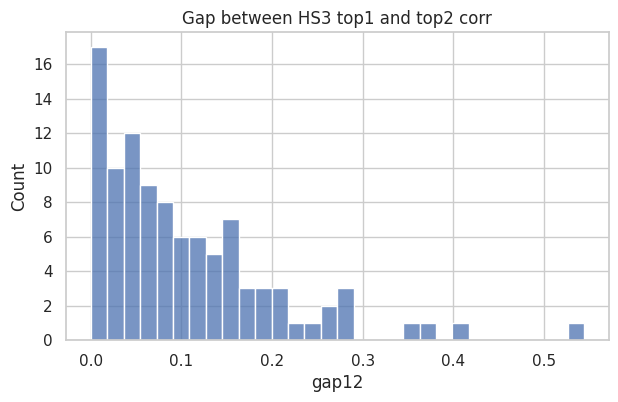

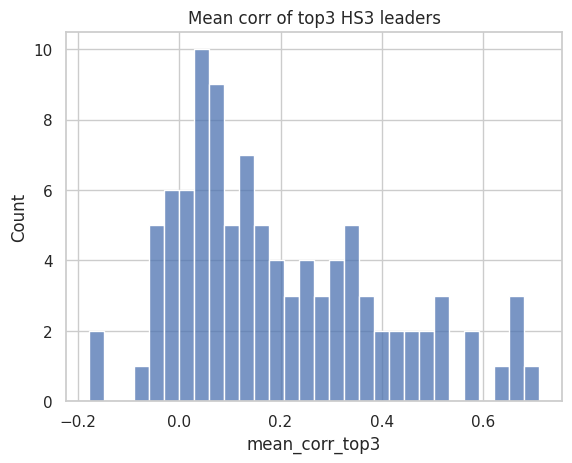

In [94]:
# 1) follower별 top3 HS3 leader
top3 = (
    pairs_hs3.groupby("follow_item", group_keys=False)
             .apply(lambda df: df.sort_values("corr", ascending=False).head(3))
             .reset_index(drop=True)
)
top3.head()


# 2) corr gap 계산
gap_records = []

for f in top3["follow_item"].unique():
    df_f = top3[top3["follow_item"] == f].sort_values("corr", ascending=False)

    if len(df_f) >= 2:
        gap12 = df_f["corr"].iloc[0] - df_f["corr"].iloc[1]
    else:
        gap12 = np.nan

    gap_records.append({
        "follow_item": f,
        "gap12": gap12,
        "mean_corr_top3": df_f["corr"].mean(),
        "n_leaders": len(df_f),
    })

gap_df = pd.DataFrame(gap_records)
gap_df.head()

# 3) histogram
plt.figure(figsize=(7,4))
sns.histplot(gap_df["gap12"], bins=30)
plt.title("Gap between HS3 top1 and top2 corr")
plt.show()

sns.histplot(gap_df["mean_corr_top3"], bins=30)
plt.title("Mean corr of top3 HS3 leaders")
plt.show()


corr ≥ 0.2: 91 items
corr ≥ 0.3: 91 items
corr ≥ 0.4: 90 items


/tmp/ipykernel_147805/1882947071.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: df.sort_values("max_corr", ascending=False).head(3)) \


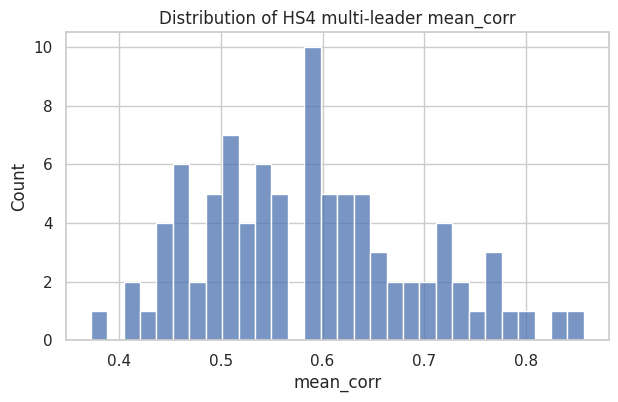

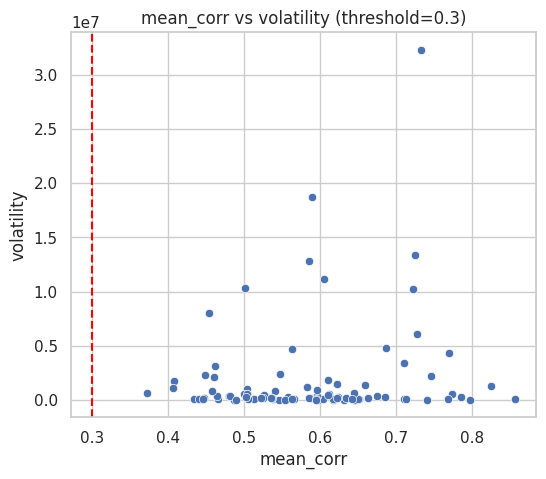

In [79]:
# pairs_hs4 : HS4 → HS4 pairs

top3_hs4 = pairs_hs4.groupby("following_item_id") \
                    .apply(lambda df: df.sort_values("max_corr", ascending=False).head(3)) \
                    .reset_index(drop=True)

mean_corr = top3_hs4.groupby("following_item_id")["max_corr"].mean().reset_index()
mean_corr.columns = ["item_id","mean_corr"]

# threshold test
thresholds = [0.2, 0.3, 0.4]

for th in thresholds:
    count = (mean_corr["mean_corr"] >= th).sum()
    print(f"corr ≥ {th}: {count} items")

# distribution plot
plt.figure(figsize=(7,4))
sns.histplot(mean_corr["mean_corr"], bins=30)
plt.title("Distribution of HS4 multi-leader mean_corr")
plt.show()

# volatility relation
df_rel = mean_corr.merge(follower_meta[["item_id","volatility","zero_ratio"]], on="item_id")

plt.figure(figsize=(6,5))
sns.scatterplot(data=df_rel, x="mean_corr", y="volatility")
plt.axvline(0.3, color="red", linestyle="--")
plt.title("mean_corr vs volatility (threshold=0.3)")
plt.show()


In [101]:
# ④ HS4 multi-leader lag EDA
def eda_hs4_multi_leader(pairs_hs4):
    print("=== HS4 Multi-Leader Lag EDA ===")

    # follower별 top3 leader 선정
    top3 = (
        pairs_hs4.groupby("following_item_id")
                 .apply(lambda df: df.sort_values("max_corr", ascending=False).head(3))
                 .reset_index(drop=True)
    )

    # follower별 평균 corr
    mean_corr = top3.groupby("following_item_id")["max_corr"].mean().reset_index()
    mean_corr.columns = ["item_id", "mean_corr"]

    # 히스토그램
    plt.figure(figsize=(7,4))
    sns.histplot(mean_corr["mean_corr"], bins=30)
    plt.axvline(0.3, color="red", linestyle="--", label="0.3 threshold")
    plt.title("HS4 multi-leader mean_corr distribution")
    plt.legend()
    plt.show()

    print(mean_corr.sort_values("mean_corr", ascending=False).head(10))
    return mean_corr


In [102]:
# ⑤ HS3 rolling EDA
def eda_hs3_rolling(pivot_hs3, pivot_item, follower_meta, hs3_map):
    print("=== HS3 Rolling EDA ===")

    results = []
    lags = [1,2,3,4,5,6]

    for hs3 in pivot_hs3.index:
        series_hs3 = pivot_hs3.loc[hs3].values.astype(float)

        # rolling 변환
        roll3 = pd.Series(series_hs3).rolling(3, min_periods=1).mean().values
        roll6 = pd.Series(series_hs3).rolling(6, min_periods=1).mean().values

        followers = hs3_map.get(hs3, [])

        for f in followers:
            if f not in pivot_item.index:
                continue

            series_item = pivot_item.loc[f].values.astype(float)

            for lag in lags:
                if len(series_item) <= lag:
                    continue

                base_corr = np.corrcoef(series_hs3[:-lag], series_item[lag:])[0,1]
                r3_corr   = np.corrcoef(roll3[:-lag], series_item[lag:])[0,1]
                r6_corr   = np.corrcoef(roll6[:-lag], series_item[lag:])[0,1]

                results.append({
                    "hs3": hs3,
                    "item_id": f,
                    "lag": lag,
                    "base_corr": base_corr,
                    "roll3_corr": r3_corr,
                    "roll6_corr": r6_corr
                })

    df = pd.DataFrame(results)

    # corr 차이 히스토그램
    df["improve3"] = df["roll3_corr"] - df["base_corr"]
    df["improve6"] = df["roll6_corr"] - df["base_corr"]

    plt.figure(figsize=(7,4))
    sns.histplot(df["improve3"], bins=30)
    plt.title("Rolling(3) improvement over base")
    plt.show()

    plt.figure(figsize=(7,4))
    sns.histplot(df["improve6"], bins=30)
    plt.title("Rolling(6) improvement over base")
    plt.show()

    print(df.sort_values("improve3", ascending=False).head(10))
    return df


In [103]:
# ⑥ Calendar feature EDA
def eda_calendar_features(monthly):

    print("=== Calendar Feature EDA ===")

    df = monthly.copy()
    df["ym"] = pd.to_datetime(df["year"].astype(str) + "-" + df["month"].astype(str).str.zfill(2))

    # 월별 합계 시각화
    monthly_sum = df.groupby(["year","month"])["total_value"].sum().reset_index()

    plt.figure(figsize=(10,4))
    sns.lineplot(data=monthly_sum, x="month", y="total_value", hue="year")
    plt.title("Global Monthly Seasonality")
    plt.show()

    # HS3별 seasonality
    hs3_month = (
        df.groupby(["hs3","month"])["total_value"].mean().reset_index()
    )

    plt.figure(figsize=(12,6))
    sns.lineplot(data=hs3_month, x="month", y="total_value", hue="hs3", legend=False)
    plt.title("HS3-wise Seasonality Pattern")
    plt.show()

    return hs3_month


In [105]:
# item_id → hs4 → hs3 연결
df_map = train[["item_id", "hs4"]].drop_duplicates()
df_map["hs4"] = df_map["hs4"].astype(str).str.zfill(4)
df_map["hs3"] = df_map["hs4"].str[:3].astype(int)

# hs3 → item list 딕셔너리 생성
hs3_map = (
    df_map.groupby("hs3")["item_id"]
          .apply(list)
          .to_dict()
)

print("hs3_map 예시 5개:")
for k in list(hs3_map.keys())[:5]:
    print(k, "→", hs3_map[k][:5])


hs3_map 예시 5개:
121 → ['JBVHSUWY']
200 → ['ELQGMQWE']
210 → ['AHMDUILJ']
250 → ['XIPPENFQ']
252 → ['FTSVTTSR', 'XMKRPGLB']


=== HS3 Rolling EDA ===


/data/ephemeral/home/py310/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/ephemeral/home/py310/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


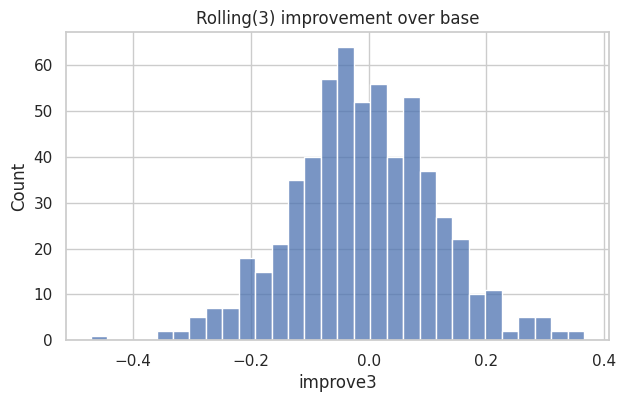

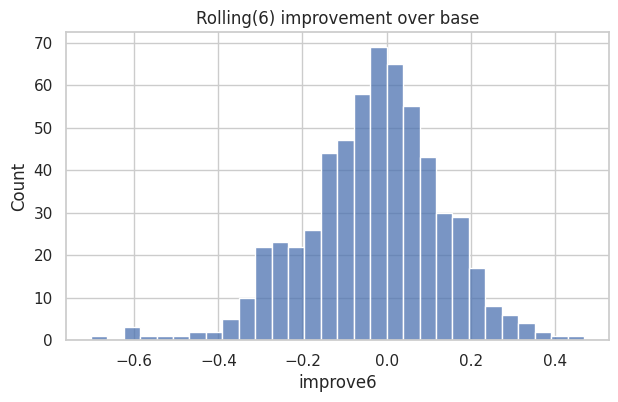

     hs3   item_id  lag  base_corr  roll3_corr  roll6_corr  improve3  improve6
550  850  UQYUIVVR    5  -0.193937    0.172022   -0.052699  0.365959  0.141238
275  381  NAQIHUKZ    6  -0.068145    0.270139    0.304140  0.338284  0.372286
267  381  STZDBITS    4  -0.179282    0.137021   -0.071588  0.316304  0.107695
567  852  VMAQSTJE    4  -0.021102    0.290919    0.278136  0.312021  0.299238
28   252  FTSVTTSR    5  -0.138923    0.161023   -0.034650  0.299947  0.104273
424  570  OKMBFVKS    5   0.111511    0.407780    0.474005  0.296269  0.362495
425  570  OKMBFVKS    6   0.142025    0.435359    0.461265  0.293334  0.319240
54   280  RCBZUSIM    1  -0.045787    0.246977   -0.009137  0.292765  0.036650
7    200  ELQGMQWE    2   0.052359    0.341895    0.396294  0.289536  0.343935
357  480  ZXERAXWP    4   0.060718    0.334984    0.217547  0.274266  0.156830


In [107]:
# 🔧 index 정리(강력 추천)
pivot_hs3.index = pivot_hs3.index.astype(int)
pivot_item.index = pivot_item.index.astype(str)

# 재실행
df_rolling = eda_hs3_rolling(pivot_hs3, pivot_item, follower_meta, hs3_map)


=== HS4 Multi-Leader Lag EDA ===


/tmp/ipykernel_147805/4274564092.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: df.sort_values("max_corr", ascending=False).head(3))


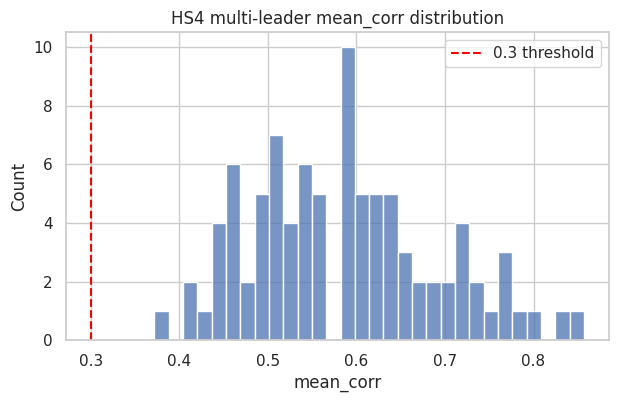

     item_id  mean_corr
39  LLHREMKS   0.856808
57  QVLMOEYE   0.824911
15  DJBLNPNC   0.797489
25  FTSVTTSR   0.785267
8   BSRMSVTC   0.773482
56  QRKRBYJL   0.770001
31  IGDVVKUD   0.769185
16  DNMPSKTB   0.746799
21  FDXPMYGF   0.741691
3   ATLDMDBO   0.733705
=== HS3 Rolling EDA ===


/data/ephemeral/home/py310/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/ephemeral/home/py310/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


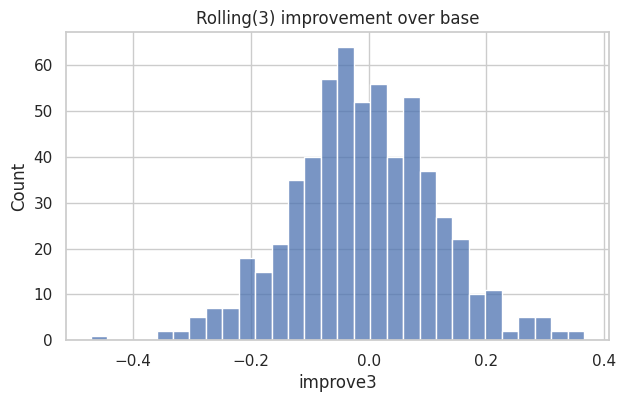

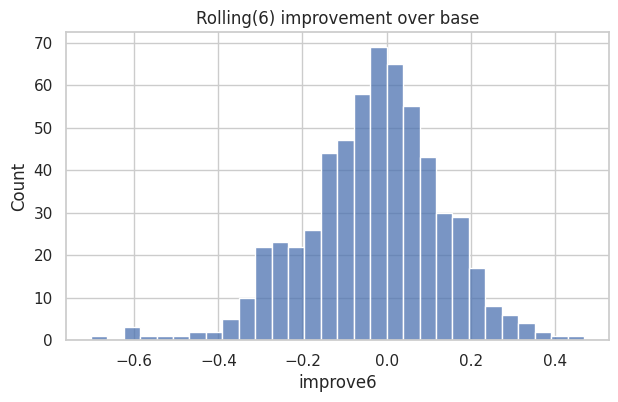

     hs3   item_id  lag  base_corr  roll3_corr  roll6_corr  improve3  improve6
550  850  UQYUIVVR    5  -0.193937    0.172022   -0.052699  0.365959  0.141238
275  381  NAQIHUKZ    6  -0.068145    0.270139    0.304140  0.338284  0.372286
267  381  STZDBITS    4  -0.179282    0.137021   -0.071588  0.316304  0.107695
567  852  VMAQSTJE    4  -0.021102    0.290919    0.278136  0.312021  0.299238
28   252  FTSVTTSR    5  -0.138923    0.161023   -0.034650  0.299947  0.104273
424  570  OKMBFVKS    5   0.111511    0.407780    0.474005  0.296269  0.362495
425  570  OKMBFVKS    6   0.142025    0.435359    0.461265  0.293334  0.319240
54   280  RCBZUSIM    1  -0.045787    0.246977   -0.009137  0.292765  0.036650
7    200  ELQGMQWE    2   0.052359    0.341895    0.396294  0.289536  0.343935
357  480  ZXERAXWP    4   0.060718    0.334984    0.217547  0.274266  0.156830
=== Calendar Feature EDA ===


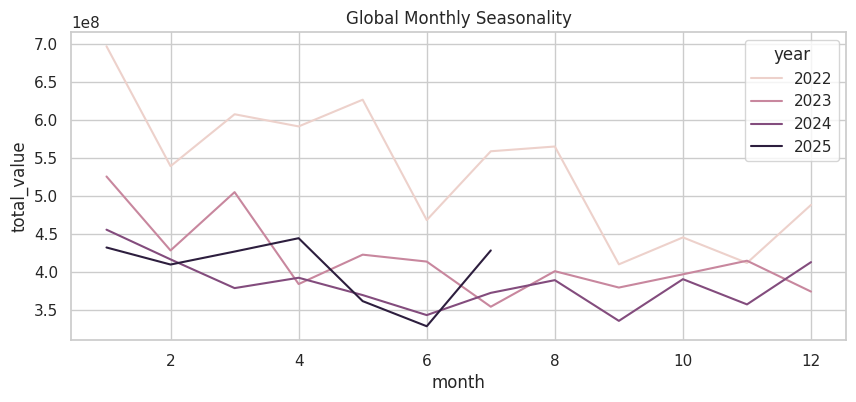

KeyError: 'hs3'

In [108]:
mean_corr_hs4 = eda_hs4_multi_leader(pairs_hs4)
df_rolling    = eda_hs3_rolling(pivot_hs3, pivot_item, follower_meta, hs3_map)
hs3_month     = eda_calendar_features(monthly)
